In [1]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim
from hyppo.ksample._utils import k_sample_transform
from hyppo.independence.base import IndependenceTest
from tqdm import tqdm

import sys
import os
import multiprocessing as mp
from joblib import Parallel, delayed
from hyppo.tools import SIMULATIONS
from hyppo.tools import power
from math import ceil

In [2]:
def test_stat_helper(vote_nodes, vote_classes, class_counts, K, kappa=3, base=2):
    """
    est_nodes : list
        Leaf indices used for voting
    eval_nodes : list
        Leaf indices in which a sample from the density subsample falls
    est_classes : list
        Voter class labels in est_node leaves
    """
    for i in range(len(vote_nodes)):
        class_counts[vote_nodes[i], vote_classes[i]] += 1

    # Total number of estimation points in each leaf.
    row_sums = class_counts.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid divide by zero.
    class_probs = class_counts / row_sums[:, None]

    # Make the nodes that have no estimation indices uniform.
    # This includes non-leaf nodes, but tha t will not affect the estimate.
    class_probs[np.argwhere(class_probs.sum(axis=1) == 0)] = [1 / K]*K
    # Apply finite sample correction and renormalize.
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / \
            (kappa*class_counts.sum(axis=1)[elem[0]])
    row_sums = class_probs.sum(axis=1)
    class_probs = class_probs / row_sums[:, None]

    # Place evaluation points in their corresponding leaf node.
    # Store evaluation posterior in a num_eval-by-num_class matrix.
    vote_class_probs = class_probs[vote_nodes]
    vote_entropies = [entropy(posterior, base=base)
                      for posterior in vote_class_probs]
    return np.mean(vote_entropies)

def uf(X, y, n_estimators=5, max_samples=.63, base=2, kappa=3, reps=100, n_jobs=None):
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              n_jobs=n_jobs,
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)

    cond_entropy = 0
    final_null_dist = [0] * 100

    #tree_est_nodes = []
    #tree_eval_nodes = []
    tree_vote_nodes = []
    tree_unsampled_indices = []

    # Get real test statistics
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0, n), sampled_indices)
        np.random.shuffle(unsampled_indices)
        tree_unsampled_indices.append(unsampled_indices)

        # Randomly split the rest into voting and evaluation.
        #vote_indices = unsampled_indices[:len(unsampled_indices)//2]
        #eval_indices = unsampled_indices[len(unsampled_indices)//2:]

        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        vote_nodes = tree.apply(X[unsampled_indices])
        tree_vote_nodes.append(vote_nodes)
        
        #est_nodes = tree.apply(X[vote_indices])
        #tree_est_nodes.append(est_nodes)
        #eval_nodes = tree.apply(X[eval_indices])
        #tree_eval_nodes.append(eval_nodes)

        cond_entropy += test_stat_helper(
            vote_nodes, y[unsampled_indices], class_counts, K)

    # Generate null dist
    # normally 1000-10,000 reps for null 
    for j in range(reps):
        for tree, unsampled_indices, vote_nodes in zip(
            model, tree_unsampled_indices, tree_vote_nodes
        ):
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            y_vote = y[unsampled_indices]
            np.random.shuffle(y_vote)
            final_null_dist[j] += test_stat_helper(
                vote_nodes, y_vote, class_counts, K)

    # note: shuffling y doesn't change these outputs
    new_final_null_dist = [entropy([np.mean(
        y), 1 - np.mean(y)], base=2) - val / n_estimators for val in final_null_dist]

    final_stat = entropy([np.mean(y), 1 - np.mean(y)],
                         base=2) - cond_entropy / n_estimators
    return final_stat, new_final_null_dist

def statistic(X, y): 
    stat, null_dist = uf(X, y, n_jobs = 4)
    #sestat = stat
    #self.null_dist = null_dist
    return stat, null_dist

In [20]:
MAX_SAMPLE_SIZE = 300
STEP_SIZE = 50
SAMP_SIZES = range(100, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 50

# simulation titles
SIM_TITLES = [
    "Linear",
    "Exponential",
    "Cubic",
    "Joint Normal",
    "Step",
    "Quadratic",
    "W-Shaped",
    "Spiral",
    "Bernoulli",
    "Logarithmic",
    "Fourth Root",
    "Sine 4\u03C0",
    "Sine 16\u03C0",
    "Square",
    "Two Parabolas",
    "Circle",
    "Ellipse",
    "Diamond",
    "Noise",
    "Independence",
]

# these tests only make sense for > 1 dimension data
#remove = ["maxmargin", "kmerf"]
#INDEP_TESTS = dict([(k, v) for k, v in INDEP_TESTS.items() if k not in remove])

#INDEP_TESTS = [
    #UF,
#]

In [21]:
from hyppo.independence import INDEP_TESTS
from hyppo.ksample import KSAMP_TESTS, KSample, k_sample_transform
from hyppo.tools import indep_sim
from hyppo.tools import gaussian_3samp, rot_ksamp


_ALL_SIMS = {
    "indep": indep_sim,
    "ksamp": rot_ksamp,
    "gauss": gaussian_3samp,
}

def _sim_gen(sim_type, sim, n, **kwargs):
    """
    Generate ``sims`` for the desired simulations.
    
    if sim_type in ["indep", "ksamp"]:
        if (
            kwargs[str(sim)] in ["multiplicative_noise", "multimodal_independence"]
            and "noise" in kwargs.keys()
        ):
            kwargs.pop("noise")
    """
    sims = _ALL_SIMS[sim_type](sim, n, **kwargs)

    return sims

def _indep_perm_stat(test, sim_type, sim, n, **kwargs):
    """
    Generates null and alternate distributions for the independence test.
    """
    #x, y = _sim_gen(sim_type=sim_type, sim = sim, n=n, **kwargs)
    #x, y = k_sample_transform([x_matrix, y_matrix])
    #y = list(map(int, y))
    x, y = rot_ksamp(sim, n=n, p=3, noise=True)
    x, y = k_sample_transform([x, y])
    #y = y.astype(int)
    obs_stat, null_dist = statistic(x, y.ravel())
    #stat, null_dist = uf(x, y, n_jobs=n_jobs)
    #permy = np.random.permutation(y)
    #perm_stat = UF._statistic(x, permy)
    pvalue = np.mean(np.asarray(null_dist) >= obs_stat)
    #print(pvalue)
    return obs_stat, pvalue

#changed reps from 1000 to 10 
def power2(test, sim_type, sim=None, n=100, alpha=0.05, reps=10, auto=False, **kwargs):
    test_stats, pvalues = map(
            np.float64,
            zip(
                *[
                    _indep_perm_stat(test=test, sim_type=sim_type, sim = sim, n = n, **kwargs)
                    for _ in range(reps)
                ]
            ),
        )
    #cutoff = np.sort(null_dist)[ceil(reps * (1 - alpha))]
    #empirical_power = (1 + (alt_dist >= cutoff).sum()) / (1 + reps)
    empirical_power = (1 + (pvalues <= 0.05).sum()) / (1 + reps) 

    return empirical_power

In [22]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

def estimate_power(sim, test):
    #est_power = np.array([np.mean([power_2samp_sample(test, trans_2samp, sim, n=i) for _ in range(POWER_REPS)])
                          #for i in SAMP_SIZES])
    print(sim)
    """"
    save_power = []
    est_power = np.array(
        [
            np.mean(
                [
                    power2(
                        test, sim_type="indep", sim=sim, n=i, p=3, auto=False, noise=True
                    )
                    for _ in tqdm(range(POWER_REPS))
                ]
            )
            for i in tqdm(SAMP_SIZES)
        ]
    )
    """
    
    est_power = []
    for i in tqdm(SAMP_SIZES): 
        print("sample size" + str(i))
        save_power = []
        for _ in tqdm(range(POWER_REPS)): 
            print("power rep" + str(_))
            temp_power = power2(test, sim_type="indep", sim=sim, n=i, p=3, auto=False, noise=True) 
            save_power.append(temp_power)
        print(save_power)
        est_power.append(np.mean(save_power))
                
        
    
    print(sim + " done")
    np.savetxt('C:/Users/siptest/Desktop/NDD/{}_{}HonestSamplingPower.csv'.format(sim, "UF"),
            est_power, delimiter=',')
    
    return est_power


In [ ]:
""""outputs = Parallel(n_jobs=-1, verbose=100)(
    [
         delayed(estimate_power)(sim_name, "UF")
         for sim_name in tqdm(SIMULATIONS.keys())
     ]
)"""

#for sim_name in tqdm(SIMULATIONS.keys()): 
    #power = estimate_power(sim_name, "UF")
power = estimate_power('multimodal_independence', "UF")

  0%|                                                                                                                                                       | 0/50 [00:00<?, ?it/s]

multimodal_independence
sample size100
power rep0



  2%|██▊                                                                                                                                            | 1/50 [00:09<07:44,  9.48s/it]

power rep1



  4%|█████▋                                                                                                                                         | 2/50 [00:18<07:32,  9.43s/it]

power rep2



  6%|████████▌                                                                                                                                      | 3/50 [00:27<07:18,  9.33s/it]

power rep3



  8%|███████████▍                                                                                                                                   | 4/50 [00:36<07:04,  9.23s/it]

power rep4



 10%|██████████████▎                                                                                                                                | 5/50 [00:45<06:52,  9.18s/it]

power rep5



 12%|█████████████████▏                                                                                                                             | 6/50 [00:55<06:42,  9.14s/it]

power rep6



 14%|████████████████████                                                                                                                           | 7/50 [01:06<06:58,  9.74s/it]

power rep7



 16%|██████████████████████▉                                                                                                                        | 8/50 [01:17<07:05, 10.13s/it]

power rep8



 18%|█████████████████████████▋                                                                                                                     | 9/50 [01:26<06:50, 10.01s/it]

power rep9



 20%|████████████████████████████▍                                                                                                                 | 10/50 [01:36<06:36,  9.92s/it]

power rep10



 22%|███████████████████████████████▏                                                                                                              | 11/50 [01:45<06:17,  9.67s/it]

power rep11



 24%|██████████████████████████████████                                                                                                            | 12/50 [01:55<06:07,  9.68s/it]

power rep12



 26%|████████████████████████████████████▉                                                                                                         | 13/50 [02:04<05:55,  9.60s/it]

power rep13



 28%|███████████████████████████████████████▊                                                                                                      | 14/50 [02:13<05:39,  9.43s/it]

power rep14



 30%|██████████████████████████████████████████▌                                                                                                   | 15/50 [02:22<05:18,  9.11s/it]

power rep15



 32%|█████████████████████████████████████████████▍                                                                                                | 16/50 [02:31<05:12,  9.20s/it]

power rep16



 34%|████████████████████████████████████████████████▎                                                                                             | 17/50 [02:40<05:03,  9.18s/it]

power rep17



 36%|███████████████████████████████████████████████████                                                                                           | 18/50 [02:50<04:55,  9.22s/it]

power rep18



 38%|█████████████████████████████████████████████████████▉                                                                                        | 19/50 [02:59<04:45,  9.20s/it]

power rep19



 40%|████████████████████████████████████████████████████████▊                                                                                     | 20/50 [03:08<04:36,  9.22s/it]

power rep20



 42%|███████████████████████████████████████████████████████████▋                                                                                  | 21/50 [03:17<04:26,  9.21s/it]

power rep21



 44%|██████████████████████████████████████████████████████████████▍                                                                               | 22/50 [03:26<04:14,  9.10s/it]

power rep22



 46%|█████████████████████████████████████████████████████████████████▎                                                                            | 23/50 [03:36<04:08,  9.22s/it]

power rep23



 48%|████████████████████████████████████████████████████████████████████▏                                                                         | 24/50 [03:45<03:58,  9.16s/it]

power rep24



 50%|███████████████████████████████████████████████████████████████████████                                                                       | 25/50 [03:54<03:52,  9.30s/it]

power rep25



 52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 26/50 [04:04<03:44,  9.37s/it]

power rep26



 54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 27/50 [04:13<03:33,  9.27s/it]

power rep27



 56%|███████████████████████████████████████████████████████████████████████████████▌                                                              | 28/50 [04:23<03:31,  9.61s/it]

power rep28



 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                           | 29/50 [04:32<03:16,  9.36s/it]

power rep29



 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 30/50 [04:41<03:04,  9.25s/it]

power rep30



 62%|████████████████████████████████████████████████████████████████████████████████████████                                                      | 31/50 [04:50<02:55,  9.24s/it]

power rep31



 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 32/50 [04:59<02:46,  9.26s/it]

power rep32



 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 33/50 [05:09<02:36,  9.20s/it]

power rep33



 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 34/50 [05:17<02:24,  9.02s/it]

power rep34



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 35/50 [05:26<02:13,  8.93s/it]

power rep35



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 36/50 [05:35<02:04,  8.86s/it]

power rep36



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 37/50 [05:44<01:57,  9.07s/it]

power rep37



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 38/50 [05:52<01:46,  8.86s/it]

power rep38



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 39/50 [06:01<01:35,  8.69s/it]

power rep39



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 40/50 [06:09<01:26,  8.69s/it]

power rep40



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 41/50 [06:18<01:18,  8.75s/it]

power rep41



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 42/50 [06:30<01:16,  9.50s/it]

power rep42



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 43/50 [06:39<01:05,  9.34s/it]

power rep43



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 44/50 [06:47<00:53,  8.95s/it]

power rep44



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 45/50 [06:55<00:43,  8.72s/it]

power rep45



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 46/50 [07:03<00:34,  8.54s/it]

power rep46



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 47/50 [07:12<00:26,  8.76s/it]

power rep47



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 48/50 [07:23<00:18,  9.25s/it]

power rep48



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 49/50 [07:31<00:08,  8.88s/it]

power rep49



  0%|                                                                                                                                                       | 0/50 [00:00<?, ?it/s]

[0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.2727272727272727, 0.2727272727272727, 0.09090909090909091, 0.18181818181818182, 0.2727272727272727, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091, 0.18181818181818182, 0.18181818181818182, 0.09090909090909091, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.2727272727272727, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091, 0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.2727272727272727, 0.09090909090909091, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.2727272727272727, 0.09090909090909091, 0.36363636363636365, 0.18181818181818182, 0.09090909090909091, 0.18181818181818182,


  2%|██▊                                                                                                                                            | 1/50 [00:11<09:30, 11.65s/it]

power rep1



  4%|█████▋                                                                                                                                         | 2/50 [00:23<09:15, 11.58s/it]

power rep2



  6%|████████▌                                                                                                                                      | 3/50 [00:34<09:02, 11.55s/it]

power rep3



  8%|███████████▍                                                                                                                                   | 4/50 [00:45<08:47, 11.48s/it]

power rep4



 10%|██████████████▎                                                                                                                                | 5/50 [00:57<08:38, 11.51s/it]

power rep5



 12%|█████████████████▏                                                                                                                             | 6/50 [01:09<08:27, 11.54s/it]

power rep6



 14%|████████████████████                                                                                                                           | 7/50 [01:20<08:14, 11.51s/it]

power rep7



 16%|██████████████████████▉                                                                                                                        | 8/50 [01:32<08:04, 11.52s/it]

power rep8



 18%|█████████████████████████▋                                                                                                                     | 9/50 [01:43<07:48, 11.43s/it]

power rep9



 20%|████████████████████████████▍                                                                                                                 | 10/50 [01:55<07:42, 11.57s/it]

power rep10



 22%|███████████████████████████████▏                                                                                                              | 11/50 [02:07<07:39, 11.79s/it]

power rep11



 24%|██████████████████████████████████                                                                                                            | 12/50 [02:19<07:30, 11.84s/it]

power rep12



 26%|████████████████████████████████████▉                                                                                                         | 13/50 [02:31<07:18, 11.85s/it]

power rep13



 28%|███████████████████████████████████████▊                                                                                                      | 14/50 [02:42<07:02, 11.74s/it]

power rep14



 30%|██████████████████████████████████████████▌                                                                                                   | 15/50 [02:54<06:49, 11.71s/it]

power rep15



 32%|█████████████████████████████████████████████▍                                                                                                | 16/50 [03:06<06:40, 11.78s/it]

power rep16



 34%|████████████████████████████████████████████████▎                                                                                             | 17/50 [03:18<06:32, 11.89s/it]

power rep17



 36%|███████████████████████████████████████████████████                                                                                           | 18/50 [03:30<06:20, 11.90s/it]

power rep18



 38%|█████████████████████████████████████████████████████▉                                                                                        | 19/50 [03:42<06:13, 12.06s/it]

power rep19



 40%|████████████████████████████████████████████████████████▊                                                                                     | 20/50 [03:54<06:01, 12.05s/it]

power rep20



 42%|███████████████████████████████████████████████████████████▋                                                                                  | 21/50 [04:07<05:51, 12.12s/it]

power rep21



 44%|██████████████████████████████████████████████████████████████▍                                                                               | 22/50 [04:19<05:41, 12.19s/it]

power rep22



 46%|█████████████████████████████████████████████████████████████████▎                                                                            | 23/50 [04:31<05:28, 12.16s/it]

power rep23



 48%|████████████████████████████████████████████████████████████████████▏                                                                         | 24/50 [04:44<05:18, 12.25s/it]

power rep24



 50%|███████████████████████████████████████████████████████████████████████                                                                       | 25/50 [04:55<05:01, 12.05s/it]

power rep25



 52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 26/50 [05:07<04:48, 12.04s/it]

power rep26



 54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 27/50 [05:20<04:43, 12.34s/it]

power rep27



 56%|███████████████████████████████████████████████████████████████████████████████▌                                                              | 28/50 [05:32<04:29, 12.27s/it]

power rep28



 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                           | 29/50 [05:44<04:12, 12.01s/it]

power rep29



 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 30/50 [05:56<04:00, 12.01s/it]

power rep30



 62%|████████████████████████████████████████████████████████████████████████████████████████                                                      | 31/50 [06:08<03:47, 11.99s/it]

power rep31



 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 32/50 [06:19<03:32, 11.81s/it]

power rep32



 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 33/50 [06:31<03:19, 11.72s/it]

power rep33



 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 34/50 [06:42<03:07, 11.70s/it]

power rep34



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 35/50 [06:54<02:54, 11.65s/it]

power rep35



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 36/50 [07:07<02:48, 12.06s/it]

power rep36



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 37/50 [07:18<02:34, 11.88s/it]

power rep37



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 38/50 [07:30<02:20, 11.74s/it]

power rep38



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 39/50 [07:41<02:08, 11.70s/it]

power rep39



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 40/50 [07:53<01:57, 11.72s/it]

power rep40



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 41/50 [08:04<01:44, 11.64s/it]

power rep41



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 42/50 [08:16<01:33, 11.66s/it]

power rep42



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 43/50 [08:28<01:21, 11.62s/it]

power rep43



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 44/50 [08:39<01:09, 11.55s/it]

power rep44



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 45/50 [08:51<00:58, 11.63s/it]

power rep45



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 46/50 [09:02<00:46, 11.61s/it]

power rep46



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 47/50 [09:14<00:34, 11.66s/it]

power rep47



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 48/50 [09:26<00:23, 11.82s/it]

power rep48



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 49/50 [09:45<00:13, 13.89s/it]

power rep49



  0%|                                                                                                                                                       | 0/50 [00:00<?, ?it/s]

[0.09090909090909091, 0.2727272727272727, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.2727272727272727, 0.18181818181818182, 0.2727272727272727, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091, 0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.36363636363636365, 0.2727272727272727, 0.18181818181818182, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.2727272727272727, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091, 0.18181818181818182, 0.18181818181818182, 0.09090909090909091, 0.2727272727272727, 0.2727272727272727, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091,


  2%|██▊                                                                                                                                            | 1/50 [00:16<13:16, 16.26s/it]

power rep1



  4%|█████▋                                                                                                                                         | 2/50 [00:31<12:45, 15.95s/it]

power rep2



  6%|████████▌                                                                                                                                      | 3/50 [00:46<12:18, 15.70s/it]

power rep3



  8%|███████████▍                                                                                                                                   | 4/50 [01:01<11:55, 15.55s/it]

power rep4



 10%|██████████████▎                                                                                                                                | 5/50 [01:17<11:45, 15.68s/it]

power rep5



 12%|█████████████████▏                                                                                                                             | 6/50 [01:33<11:34, 15.79s/it]

power rep6



 14%|████████████████████                                                                                                                           | 7/50 [01:51<11:48, 16.47s/it]

power rep7



 16%|██████████████████████▉                                                                                                                        | 8/50 [02:11<12:11, 17.41s/it]

power rep8



 18%|█████████████████████████▋                                                                                                                     | 9/50 [02:30<12:08, 17.78s/it]

power rep9



 20%|████████████████████████████▍                                                                                                                 | 10/50 [02:48<11:59, 17.98s/it]

power rep10



 22%|███████████████████████████████▏                                                                                                              | 11/50 [03:08<12:06, 18.62s/it]

power rep11



 24%|██████████████████████████████████                                                                                                            | 12/50 [03:27<11:52, 18.75s/it]

power rep12



 26%|████████████████████████████████████▉                                                                                                         | 13/50 [03:47<11:40, 18.93s/it]

power rep13


In [25]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:], n_colors=9)

def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    plt.suptitle("Multivariate Independence Testing (Increasing Sample Size)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            #sim = SIMULATIONS[count]
            
            #for test in tests:
            power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/{}_{}HonestSamplingPower.csv'.format(sim, "UF"),
                                  delimiter=',')
            col.plot(SAMP_SIZES, power, label="UF", lw=2)

            col.set_xticks([])
            if i == 3:
                col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
            col.set_ylim(-1.05, 1.05)
            col.set_yticks([])
            if j == 0:
                col.set_yticks([-1, 0, 1])
            col.set_title(sim_title[count])

    fig.text(0.5, 0.07, 'Sample Size', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('C:/Users/siptest/Desktop/NDD/indep_power_sampsize_allSim_HonestUF.png', transparent=True, bbox_inches='tight')

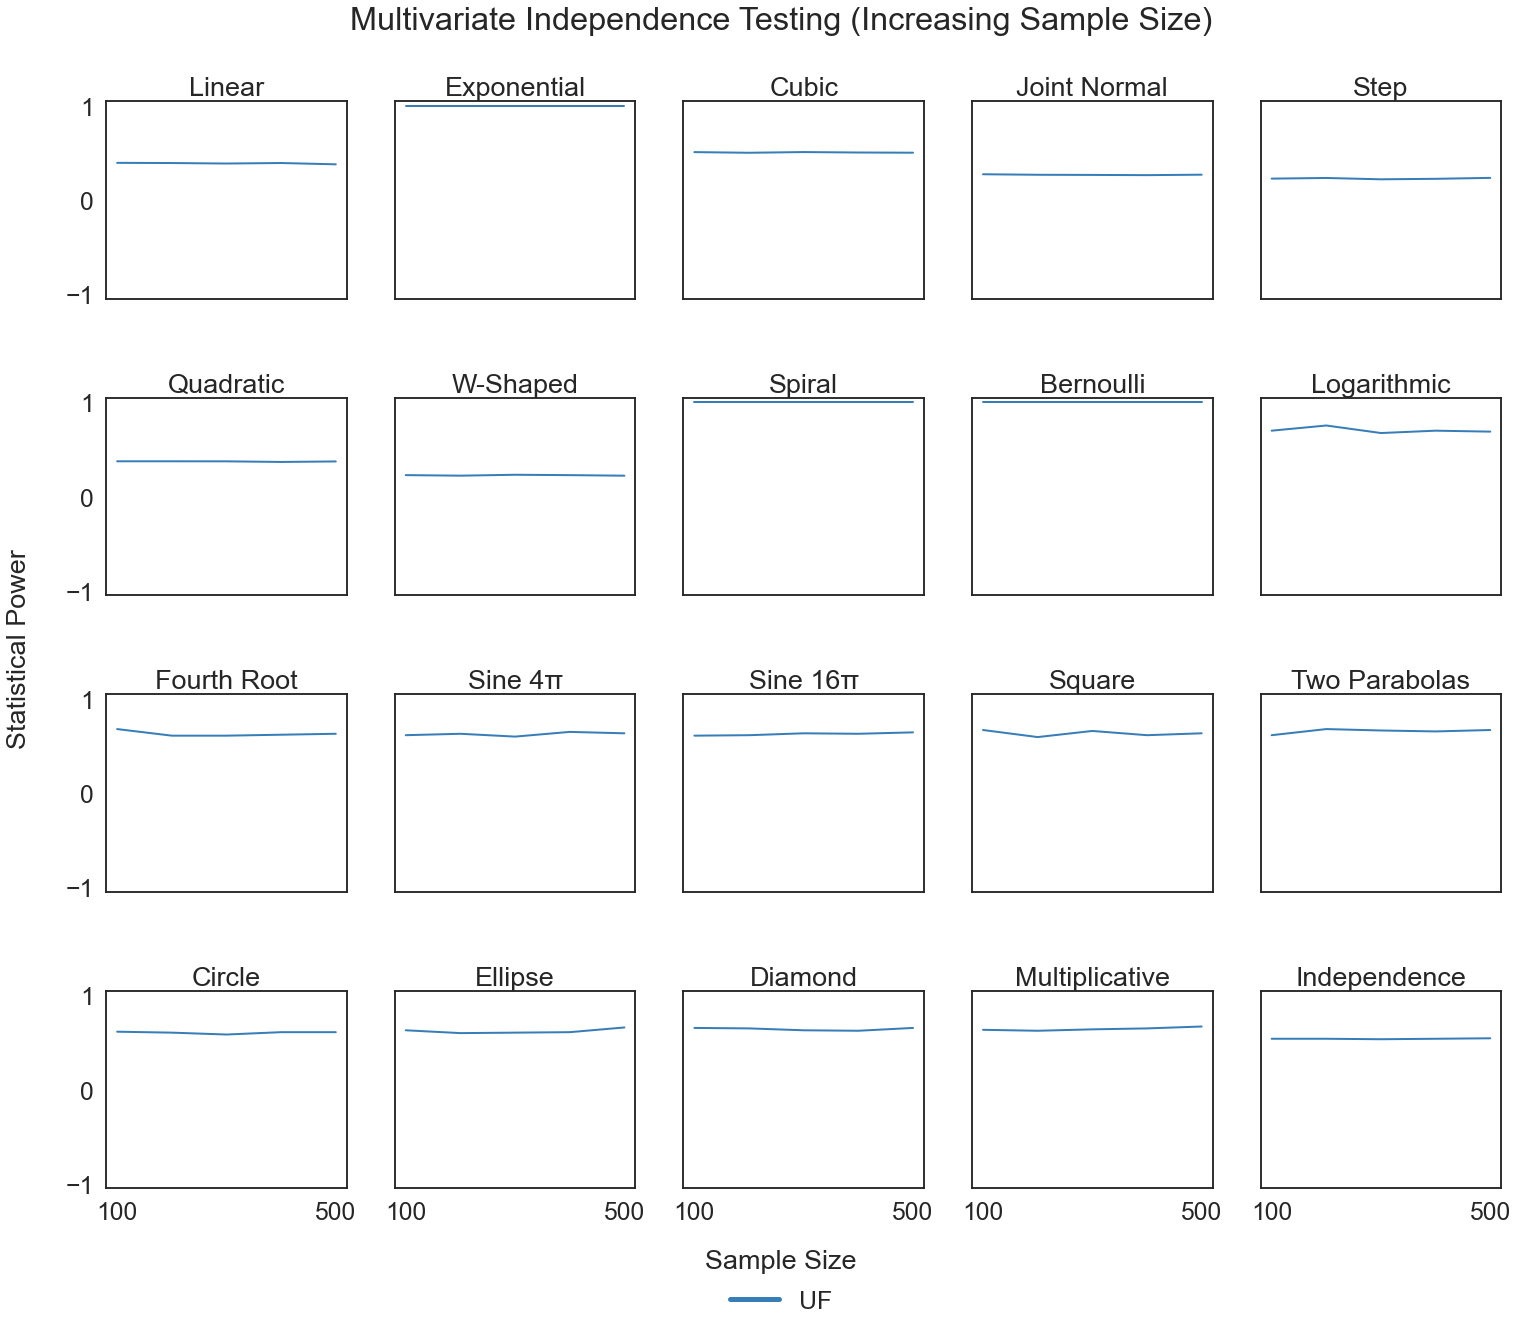

In [26]:
plot_power()